# Understanding and Improving Deep Convolutional Networks in Keras
> There are many ways to improve training by neural networks. In this chapter, we will focus on our ability to track how well a network is doing, and explore approaches towards improving convolutional neural networks. This is the Summary of lecture "Image Processing with Keras in Python", via datacamp.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Datacamp, Tensorflow-Keras, Vision, Deep_Learning]
- image: 

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Tracking learning


### Plot the learning curves
During learning, the model will store the loss function evaluated in each epoch. Looking at the learning curves can tell us quite a bit about the learning process. In this exercise, you will plot the learning and validation loss curves for a model that you will train.



In [2]:
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

train_data = train_data[(train_labels >= 0) & (train_labels < 3)][0:50].reshape(-1, 28, 28, 1)
train_labels = train_labels[(train_labels >= 0) & (train_labels < 3)][0:50]
train_labels = pd.get_dummies(train_labels).to_numpy()

test_data = test_data[(test_labels >= 0) & (test_labels < 3)][0:10].reshape(-1, 28, 28, 1)
test_labels = test_labels[(test_labels >= 0) & (test_labels < 3)][0:10]
test_labels = pd.get_dummies(test_labels).to_numpy()

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D

img_rows, img_cols = 28, 28

model = Sequential()
model.add(Conv2D(4, kernel_size=2, activation='relu', input_shape=(img_rows, img_cols, 1)))
model.add(MaxPool2D(2))
model.add(Conv2D(8, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 27, 27, 4)         20        
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 13, 13, 4)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 11, 11, 8)         296       
_________________________________________________________________
flatten_7 (Flatten)          (None, 968)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 2907      
Total params: 3,223
Trainable params: 3,223
Non-trainable params: 0
_________________________________________________________________


Epoch 1/3
4/4 [==============================] - 0s 24ms/step - loss: 11.2036 - accuracy: 0.3750 - val_loss: 4.8204 - val_accuracy: 0.7000
Epoch 2/3
4/4 [==============================] - 0s 8ms/step - loss: 1.9656 - accuracy: 0.7250 - val_loss: 2.3114 - val_accuracy: 0.8000
Epoch 3/3
4/4 [==============================] - 0s 8ms/step - loss: 0.9591 - accuracy: 0.8750 - val_loss: 1.6158 - val_accuracy: 0.8000


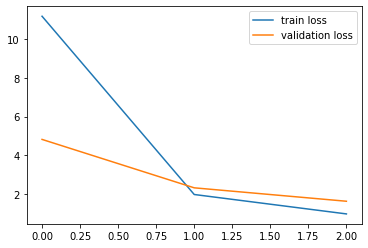

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('weights.hdf5', monitor='val_loss', save_best_only=True)

# Train the model and store the training object (including modelCheckpoint callback)
training = model.fit(train_data, train_labels, epochs=3, batch_size=10, validation_split=0.2,
                     callbacks=[checkpoint])

# Extract the history from the training object
history = training.history

# Plot the training loss
plt.plot(history['loss'], label='train loss');
# Plot the validation loss
plt.plot(history['val_loss'], label='validation loss');
plt.legend();

### Using stored weights to predict in a test set
Model weights stored in an `hdf5` file can be reused to populate an untrained model. Once the weights are loaded into this model, it behaves just like a model that has been trained to reach these weights. For example, you can use this model to make predictions from an unseen data set (e.g. `test_data`).

In [24]:
# Load the weights from file
model.load_weights('weights.hdf5')

# Predict from the first three images in the test data
# model.predict_classes(test_data) <- .predict_classes API will be decrepted
# otherway: print(model.predict(test_data[0:3]))
print(np.argmax(model.predict(test_data), axis=-1))
print(test_labels)

[2 1 1 1 1 2 0 0 1 0]
[[0 0 1]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [1 0 0]]


## Regularization
- Dropout
    - In each learning step:
        - Select a subset of the units
        - Ignore it in the forward pass
        - And in the back-propagation of error
![dropout](image/dropout.png)
- Batch Normalization
    - Rescale the outputs
- Disharmony between dropout and batch normalization 
    - Dropout tends to slow down learning, making it more incremental
    - Batch Normalization tends to make learning go faster
    - Their effects together may in fact each other.

### Adding dropout to your network
Dropout is a form of regularization that removes a different random subset of the units in a layer in each round of training. In this exercise, we will add dropout to the convolutional neural network that we have used in previous exercises:

1. Convolution (15 units, kernel size 2, 'relu' activation)
2. Dropout (20%)
3. Convolution (5 units, kernel size 2, 'relu' activation)
4. Flatten
5. Dense (3 units, 'softmax' activation)

In [25]:
from tensorflow.keras.layers import Dropout

model = Sequential()

# Add a convolutional layer
model.add(Conv2D(15, kernel_size=2, activation='relu', input_shape=(img_rows, img_cols, 1)))

# Add a dropout layer
model.add(Dropout(0.2))
         
# Add another convolutional layer
model.add(Conv2D(5, kernel_size=2, activation='relu'))

# Flatten and feed to output layer
model.add(Flatten())
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 27, 27, 15)        75        
_________________________________________________________________
dropout (Dropout)            (None, 27, 27, 15)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 26, 26, 5)         305       
_________________________________________________________________
flatten_8 (Flatten)          (None, 3380)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 10143     
Total params: 10,523
Trainable params: 10,523
Non-trainable params: 0
_________________________________________________________________


### Add batch normalization to your network
Batch normalization is another form of regularization that rescales the outputs of a layer to make sure that they have mean 0 and standard deviation 1. In this exercise, we will add batch normalization to the convolutional neural network that we have used in previous exercises:

1. Convolution (15 units, kernel size 2, 'relu' activation)
2. Batch normalization
3. Convolution (5 unites, kernel size 2, 'relu' activation)
4. Flatten
5. Dense (3 units, 'softmax' activation)

In [27]:
from tensorflow.keras.layers import BatchNormalization

model = Sequential()

# Add a convolutional layer
model.add(Conv2D(15, kernel_size=2, activation='relu', input_shape=(img_rows, img_cols, 1)))

# Add batch normalization layer
model.add(BatchNormalization())

# Add another convolutional layer
model.add(Conv2D(5, kernel_size=2, activation='relu'))

# Flatten and feed to output layer
model.add(Flatten())
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 27, 27, 15)        75        
_________________________________________________________________
batch_normalization (BatchNo (None, 27, 27, 15)        60        
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 26, 26, 5)         305       
_________________________________________________________________
flatten_9 (Flatten)          (None, 3380)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 10143     
Total params: 10,583
Trainable params: 10,553
Non-trainable params: 30
_________________________________________________________________


## Interpreting the model

### Extracting a kernel from a trained network
One way to interpret models is to examine the properties of the kernels in the convolutional layers. In this exercise, you will extract one of the kernels from a convolutional neural network with weights that you saved in a hdf5 file.

In [30]:
model = Sequential()

model.add(Conv2D(5, kernel_size=2, activation='relu', input_shape=(img_rows, img_cols, 1)))
model.add(Conv2D(15, kernel_size=2, activation='relu'))
model.add(MaxPool2D(2))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))

model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint('weights_fasion.hdf5', monitor='val_loss', save_best_only=True)

model.fit(train_data, train_labels, epochs=3, validation_split=0.2, batch_size=10,
          callbacks=[checkpoint]);

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 27, 27, 5)         25        
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 26, 26, 15)        315       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 13, 13, 15)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 2535)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 7608      
Total params: 7,948
Trainable params: 7,948
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
4/4 [==============================] - 0s 24ms/step - loss: 49.7362 - accuracy: 0.3750 - val_loss: 13.1609 

In [33]:
# Load the weights into the model
model.load_weights('weights_fasion.hdf5')

# Get the first convolutional layer from the model
c1 = model.layers[0]

# Get the weights of the first convolutional layer
weights1 = c1.get_weights()

# Pull out the first channel of the first kernel in the first layer
kernel = weights1[0][..., 0, 0]
print(kernel)
print(kernel.shape)

[[-0.01779658  0.17339064]
 [ 0.17013     0.43874028]]
(2, 2)


### Visualizing kernel responses
One of the ways to interpret the weights of a neural network is to see how the kernels stored in these weights "see" the world. That is, what properties of an image are emphasized by this kernel. In this exercise, we will do that by convolving an image with the kernel and visualizing the result. Given images in the `test_data` variable, a function called `extract_kernel()` that extracts a kernel from the provided network, and the function called `convolution()` that we defined in the first chapter, extract the kernel, load the data from a file and visualize it with `matplotlib`.

In [34]:
def convolution(image, kernel):
    kernel = kernel - kernel.mean()
    result = np.zeros(image.shape)

    for ii in range(image.shape[0]-2):
        for jj in range(image.shape[1]-2):
            result[ii, jj] = np.sum(image[ii:ii+2, jj:jj+2] * kernel)

    return result

In [41]:
# Convolve with the fourth image in test_data
out = convolution(test_data[3, :, :, 0], kernel)

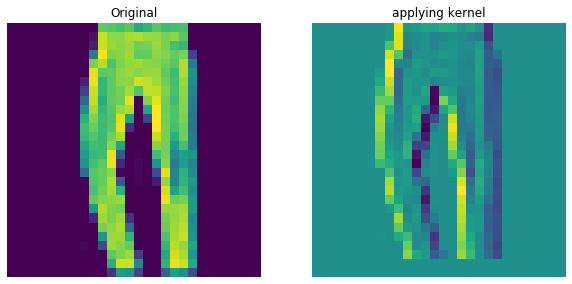

In [42]:
def plot_comparison(img_original, img_filtered, img_title_filtered):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 8), sharex=True, sharey=True)
    ax1.imshow(img_original)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(img_filtered)
    ax2.set_title(img_title_filtered)
    ax2.axis('off')
    
plot_comparison(test_data[3, :, :, 0], out, 'applying kernel')

## Summary
- Learn
    - Image Classification
    - Convolution
    - Reducing the number of parameters
        - Tweaking your convolutions
        - Adding pooling layers
    - Improving network
        - Regularization
    - Understanding network
        - Monitoring learning
        - Interpreting the parameters